In [1]:
import os
import json
import cv2
import csv
import numpy as np
from PIL import Image, ImageDraw
from skimage import measure
from sklearn.model_selection import train_test_split
from scipy.ndimage import label
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import tensorflow_addons as tfa 
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,
                                     Dropout, BatchNormalization, Activation, Add, Multiply, Reshape,
                                     GlobalAveragePooling2D, Dense, LayerNormalization, MultiHeadAttention,
                                     ZeroPadding2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy, Loss
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K

c:\Users\witol\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\witol\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [2]:
IMAGE_SIZE = (128, 128)
NUM_CLASSES = 4

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


**Definiowanie funkcji pomocniczych**

In [3]:
def load_files(path):
    images = []
    jsons = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                images.append(os.path.join(root, file))
            elif file.endswith('.json'):
                jsons.append(os.path.join(root, file))
    return images, jsons

def load_images(image_paths):
    return [Image.open(path).convert("RGB") for path in image_paths]

def resize_images(images):
    return [img.resize(IMAGE_SIZE) for img in images]

def load_json_data(json_paths):
    data = []
    for json_path in json_paths:
        with open(json_path, 'r') as f:
            data.append(json.load(f))
    return data

def create_masks(image_size, nucleus_data, original_size=(1228, 1228), radius=3):
    masks = []
    for idx, nuclei in enumerate(nucleus_data):
        mask = Image.new('L', image_size, 0)  
        draw = ImageDraw.Draw(mask)
        x_scale = image_size[0] / original_size[0]
        y_scale = image_size[1] / original_size[1]

        for nucleus in nuclei:
            x = int(nucleus['x'] * x_scale)
            y = int(nucleus['y'] * y_scale)
            label_id = nucleus['label_id']

            if label_id not in [1, 2, 3]:
                print(f"Uwaga: Niezidentyfikowana etykieta w jądrze {label_id} w masce {idx + 1}")
                continue  

            draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=label_id)

        masks.append(np.array(mask))

    return masks

**Funkcje do wstępnego przetwarzania obrazów i masek**

In [4]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_array = np.array(img)
        img_array = img_array / 255.0
        processed_images.append(img_array)
    return np.array(processed_images)

def preprocess_masks(masks):
    print(f"Kształt masek przed kodowaniem one-hot: {masks.shape}")
    
    if len(masks.shape) == 3:
        masks_clipped = np.clip(masks.astype(int), 0, NUM_CLASSES - 1)
        one_hot_encoded_masks = np.eye(NUM_CLASSES)[masks_clipped]   
        one_hot_encoded_masks = one_hot_encoded_masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], NUM_CLASSES)
    else:
        raise ValueError(f"Nieoczekiwany kształt masek: {masks.shape}")
    
    print(f"Kształt masek po kodowaniu one-hot: {one_hot_encoded_masks.shape}")
    
    return one_hot_encoded_masks

def preprocess_images_and_masks(images, masks):
    print(f"Kształt masek przed przetwarzaniem: {masks.shape}")

    images = preprocess_images(images)
    
    if masks.shape[-1] != NUM_CLASSES:
        masks = preprocess_masks(masks)
    else:
        print("Maski są już zakodowane w formacie one-hot, pomijam kodowanie.")
    
    print(f"Kształt masek po przetworzeniu: {masks.shape}")
    
    return images, masks


**Funkcje do filtrowania obrazów**

In [5]:
def filter_images_with_min_cells(images, masks, min_cells=10):
    filtered_images = []
    filtered_masks = []
    discarded_count = 0

    for img, mask in zip(images, masks):
        unique_labels = np.unique(mask)
        cell_count = np.sum([np.sum(mask == label_id) for label_id in [1, 2, 3]])
        if cell_count >= min_cells:
            if img.size == mask.size * 3: 
                filtered_images.append(np.array(img))
                filtered_masks.append(np.array(mask))
        else:
            discarded_count += 1

    print(f"Liczba odrzuconych obrazów: {discarded_count}")

    return np.array(filtered_images), np.array(filtered_masks)


**Funkcje do kodowania masek**

In [6]:
def one_hot_encode_masks(masks, num_classes=NUM_CLASSES):
    masks_clipped = np.clip(masks.squeeze().astype(int), 0, num_classes - 1)
    one_hot_encoded_masks = np.eye(num_classes)[masks_clipped]
    return one_hot_encoded_masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], num_classes)

def clip_mask_values(mask_batch):
    return np.clip(mask_batch, 0, NUM_CLASSES - 1)

def create_train_generator(image_generator, mask_generator):
    while True:
        X = next(image_generator)
        y = next(mask_generator)
        y = clip_mask_values(y)
        yield X, y


**Definiowanie funkcji strat i metryk**

In [7]:
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')

        weights = K.constant(class_weights)
        loss = y_true * K.log(y_pred + K.epsilon())
        loss = loss * weights
        loss = -K.sum(loss, -1)

        return K.mean(loss)
    return loss

def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    axes = tuple(range(1, K.ndim(y_pred) - 1))
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    dice = K.mean((numerator + smooth) / (denominator + smooth))
    return 1 - dice

# def combined_loss(class_weights):
#     def loss(y_true, y_pred):
#         loss_ce = weighted_categorical_crossentropy(class_weights)(y_true, y_pred)
#         loss_dice = dice_loss_multiclass(y_true, y_pred)
#         return 0.5 * loss_ce + 0.5 * loss_dice
#     return loss

class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights, reduction=tf.keras.losses.Reduction.AUTO, name='CombinedLoss'):
        super(CombinedLoss, self).__init__(reduction=reduction, name=name)
        self.class_weights = K.constant(class_weights)

    def call(self, y_true, y_pred):
        # Compute weighted categorical crossentropy
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')

        weights = self.class_weights
        loss_ce = y_true * K.log(y_pred + K.epsilon())
        loss_ce = loss_ce * weights
        loss_ce = -K.sum(loss_ce, -1)
        loss_ce = K.mean(loss_ce)

        # Compute dice loss
        axes = tuple(range(1, K.ndim(y_pred) - 1))
        numerator = 2. * K.sum(y_pred * y_true, axes)
        denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
        dice = K.mean((numerator + 1e-6) / (denominator + 1e-6))
        loss_dice = 1 - dice

        return 0.5 * loss_ce + 0.5 * loss_dice

    def get_config(self):
        config = super(CombinedLoss, self).get_config()
        config.update({
            'class_weights': self.class_weights.numpy().tolist(),
        })
        return config



def iou_metric(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1e-6) / (union + 1e-6), axis=0)
    return iou

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


**Definiowanie funkcji modelu U-Net**

*Bloki sieci*

In [8]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)  
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.35)(x)  
    return x

def max_pool(input_tensor):
    return MaxPooling2D((2, 2), strides=2)(input_tensor)

def upsample_block(input_tensor, skip_features, num_filters):
    x = UpSampling2D(size=(2, 2))(input_tensor)
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)

    if x.shape[1] != skip_features.shape[1] or x.shape[2] != skip_features.shape[2]:
        x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    
    x = concatenate([x, skip_features])
    return x

*Bloki uwagi i sekwencyjnej ekstytacji*

In [9]:
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, kernel_size=2, strides=2, padding='same')(x)
    phi_g = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    concat = Add()([theta_x, phi_g])
    relu_concat = Activation('relu')(concat)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(relu_concat)
    sigmoid_psi = Activation('sigmoid')(psi)
    upsample_sigmoid_psi = UpSampling2D(size=(2, 2))(sigmoid_psi)
    upsample_sigmoid_psi = Conv2D(K.int_shape(x)[-1], kernel_size=1, padding='same')(upsample_sigmoid_psi)
    attn_coefficients = Multiply()([x, upsample_sigmoid_psi])
    return attn_coefficients

def self_attention_block(input_tensor, num_heads=4):
    norm_input = LayerNormalization()(input_tensor)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=64)(norm_input, norm_input)
    attention_output = Add()([attention_output, input_tensor])
    return attention_output

def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)
    
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = Multiply()([input_tensor, se])
    return x

*Definicja U-Net i modelu*

In [10]:
def unet(inputs, filterd_vector=[32, 64, 128, 256, 512]):
    conv1 = conv_block(inputs, filterd_vector[0])
    pool1 = max_pool(conv1)

    conv2 = conv_block(pool1, filterd_vector[1])
    pool2 = max_pool(conv2)

    conv3 = conv_block(pool2, filterd_vector[2])
    pool3 = max_pool(conv3)

    conv4 = conv_block(pool3, filterd_vector[3])
    pool4 = max_pool(conv4)

    conv5 = conv_block(pool4, filterd_vector[4])

    se_attention = self_attention_block(conv5)
    se_attention = se_block(se_attention)

    up6 = upsample_block(se_attention, attention_block(conv4, conv5, filterd_vector[3]), filterd_vector[3])
    up7 = upsample_block(up6, attention_block(conv3, up6, filterd_vector[2]), filterd_vector[2])
    up8 = upsample_block(up7, attention_block(conv2, up7, filterd_vector[1]), filterd_vector[1])
    up9 = upsample_block(up8, attention_block(conv1, up8, filterd_vector[0]), filterd_vector[0])

    return up9

def stacked_unet(num_filters, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_unets=1):
    inputs = Input(input_shape)
    x = inputs

    for _ in range(num_unets):
        x = unet(x, num_filters)
    outputs = Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

**Funkcje treningu i ewaluacji**

*Funkcja do trenowania modelu*

In [11]:
def train_model(train_images_np, train_masks_np, val_images_np, val_masks_np, test_images_np, test_masks_np, num_filters, epochs, batch_size=2, unet_size=1):
    y_train_labels = np.argmax(train_masks_np, axis=-1).flatten()
    class_counts = np.bincount(y_train_labels, minlength=NUM_CLASSES)
    total_pixels = len(y_train_labels)
    class_frequencies = class_counts / total_pixels
    class_weights = 1.0 / (class_frequencies + 1e-6)
    class_weights = class_weights / np.sum(class_weights)
    print("Wagi klas:", class_weights)

    loss_function = CombinedLoss(class_weights)

    model = stacked_unet(num_filters=num_filters, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_unets=unet_size)

    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)

    model.compile(optimizer=optimizer, 
                  loss=loss_function, 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), iou_metric])


    save_folder = f'Model/{unet_size}_unets_{num_filters[-1]}_filters'
    os.makedirs(save_folder, exist_ok=True)

    checkpoint = ModelCheckpoint(os.path.join(save_folder, f'best_model_{unet_size}_unets_{num_filters[-1]}_filters_{epochs}_epoch_{batch_size}_batch.h5'),
                                 monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)  
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    lr_scheduler = LearningRateScheduler(scheduler)

    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 42

    image_generator = image_datagen.flow(
        train_images_np,
        batch_size=batch_size,
        seed=seed,
        shuffle=True)

    mask_generator = mask_datagen.flow(
        train_masks_np.astype(np.uint8),
        batch_size=batch_size,
        seed=seed,
        shuffle=True)

    train_generator = create_train_generator(image_generator, mask_generator)


    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_images_np) // batch_size,
        epochs=epochs,
        validation_data=(val_images_np, val_masks_np),
        callbacks=[checkpoint, early_stopping, lr_scheduler]
    )

    return model, history




def visualize_predictions(model, test_images, test_masks, num_examples=5):
    predictions = model.predict(test_images)
    y_pred_labels = np.argmax(predictions, axis=-1)
    y_true_labels = np.argmax(test_masks, axis=-1)

    for i in range(num_examples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i])
        plt.title('Oryginalny obraz')

        plt.subplot(1, 3, 2)
        plt.imshow(y_true_labels[i])
        plt.title('Prawdziwa maska')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred_labels[i])
        plt.title('Predykcja modelu')

        plt.show()



*Funkcje do uruchamiania treningu i wykresów*

In [12]:
def run_training(train_images_np, train_masks_np, val_images_np, val_masks_np, test_images_np, test_masks_np, filters_list, batch_size_list, epochs_list):
    for i in range(1, 4):     
        for num_filters in filters_list:
            num_unets = i
            for batch_size in batch_size_list:
                for epochs in epochs_list:
                    K.clear_session()
                    print(f"\nTrening modelu z {num_unets} U-Net, {num_filters[-1]} filtrami, batch_size = {batch_size}, epochs = {epochs}\n")

                    model, history = train_model(
                        train_images_np, train_masks_np,
                        val_images_np, val_masks_np,
                        test_images_np, test_masks_np,
                        num_filters=num_filters,
                        epochs=epochs, batch_size=batch_size,
                        unet_size=num_unets
                    )

                    
                    save_folder = f'Model/{num_unets}_unets_{num_filters[-1]}_filters'
                    plot_training_history(history, save_folder, filters=num_filters[-1], epochs=epochs)
                    
                    K.clear_session()      

def plot_training_history(history, save_folder, filters, epochs):
    os.makedirs(save_folder, exist_ok=True)
    
    plt.figure()
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_folder, f'loss_{filters}_filters_{epochs}_epoch.png'))
    plt.close()

    plt.figure()
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_folder, f'acc_{filters}_filters_{epochs}_epoch.png'))
    plt.close()

*Funkcje do ewaluacji modelu*

In [13]:
def count_cells(y_pred_labels, class_id):
    labeled_array = measure.label(y_pred_labels == class_id, connectivity=1)
    return np.max(labeled_array)

def combine_pixels_for_all_classes(predictions):
    results = {
        "Pozytywne": 0,
        "Negatywne": 0,
        "TLL": 0
    }
    
    for class_index, class_name in enumerate(["Pozytywne", "Negatywne", "TLL"], start=1):
        class_mask = predictions[..., class_index]
        
        labeled_array, num_features = label(class_mask > 0.5)
        
        results[class_name] = num_features
    
    return results

def evaluate_model_with_channels(model, model_name, test_images_np, test_masks_np, csv_filename='evaluation_results.csv'):
    import numpy as np
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    from skimage.measure import label
    import csv

    predictions = model.predict(test_images_np)
    y_pred_labels = np.argmax(predictions, axis=-1)
    y_true_labels = np.argmax(test_masks_np, axis=-1)

    # Spłaszczanie tablic etykiet
    y_true_labels_flat = y_true_labels.flatten()
    y_pred_labels_flat = y_pred_labels.flatten()

    # Upewnij się, że etykiety są typu całkowitego
    y_true_labels_flat = y_true_labels_flat.astype(np.int32)
    y_pred_labels_flat = y_pred_labels_flat.astype(np.int32)

    # Uzyskanie raportu klasyfikacji jako słownik
    report = classification_report(
        y_true_labels_flat,
        y_pred_labels_flat,
        labels=[0, 1, 2, 3],
        target_names=['Background', 'Pozytywne', 'Negatywne', 'TLL'],
        output_dict=True,
        zero_division=0  # Zapobieganie dzieleniu przez zero
    )
    # Wydrukowanie raportu klasyfikacji
    print(classification_report(
        y_true_labels_flat,
        y_pred_labels_flat,
        labels=[0, 1, 2, 3],
        target_names=['Background', 'Pozytywne', 'Negatywne', 'TLL'],
        zero_division=0
    ))

    # Funkcja do liczenia indywidualnych komórek (obiektów)
    def count_cells(mask, class_id):
        labeled_mask = label(mask == class_id, connectivity=1)
        return np.max(labeled_mask)

    # Liczenie indywidualnych komórek w danych rzeczywistych
    total_positive_cells = count_cells(y_true_labels, 1)
    total_negative_cells = count_cells(y_true_labels, 2)
    total_tll_cells = count_cells(y_true_labels, 3)
    total_cells = total_positive_cells + total_negative_cells + total_tll_cells

    # Liczenie indywidualnych komórek w predykcjach modelu
    detected_positive_cells = count_cells(y_pred_labels, 1)
    detected_negative_cells = count_cells(y_pred_labels, 2)
    detected_tll_cells = count_cells(y_pred_labels, 3)
    total_detected_cells = detected_positive_cells + detected_negative_cells + detected_tll_cells

    # Obliczanie procentów wykrytych komórek
    positive_percentage = (detected_positive_cells / total_positive_cells) * 100 if total_positive_cells > 0 else 0
    negative_percentage = (detected_negative_cells / total_negative_cells) * 100 if total_negative_cells > 0 else 0
    tll_percentage = (detected_tll_cells / total_tll_cells) * 100 if total_tll_cells > 0 else 0
    total_detected_percentage = (total_detected_cells / total_cells) * 100 if total_cells > 0 else 0

    print(f"Liczba wszystkich komórek: {total_cells}")
    print(f"Liczba pozytywnych komórek: {total_positive_cells}")
    print(f"Liczba negatywnych komórek: {total_negative_cells}")
    print(f"Liczba komórek TLL: {total_tll_cells}")
    print(f"Wykryte pozytywne komórki: {detected_positive_cells}")
    print(f"Wykryte negatywne komórki: {detected_negative_cells}")
    print(f"Wykryte komórki TLL: {detected_tll_cells}")
    print(f"Procent wykrytych pozytywnych komórek: {positive_percentage:.2f}%")
    print(f"Procent wykrytych negatywnych komórek: {negative_percentage:.2f}%")
    print(f"Procent wykrytych komórek TLL: {tll_percentage:.2f}%")
    print(f"Procent wykrytych wszystkich komórek: {total_detected_percentage:.2f}%")

    
    precision = precision_score(y_true_labels_flat, y_pred_labels_flat, labels=[1, 2, 3], average='weighted', zero_division=0)
    recall = recall_score(y_true_labels_flat, y_pred_labels_flat, labels=[1, 2, 3], average='weighted', zero_division=0)
    f1 = f1_score(y_true_labels_flat, y_pred_labels_flat, labels=[1, 2, 3], average='weighted', zero_division=0)

    print(f"Precyzja: {precision:.2f}")
    print(f"Czułość (Recall): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    # Zapisywanie wyników do pliku CSV
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow([
                "Model", "Liczba wszystkich komórek", "Liczba pozytywnych komórek", 
                "Liczba negatywnych komórek", "Liczba komórek TLL", "Wykryte pozytywne komórki", 
                "Wykryte negatywne komórki", "Wykryte komórki TLL", "Procent wykrytych pozytywnych komórek", 
                "Procent wykrytych negatywnych komórek", "Procent wykrytych komórek TLL", 
                "Procent wykrytych wszystkich komórek", "Precyzja", "Czułość", "F1-Score"
            ])
        writer.writerow([
            model_name, total_cells, total_positive_cells, total_negative_cells, total_tll_cells,
            detected_positive_cells, detected_negative_cells, detected_tll_cells,
            positive_percentage, negative_percentage, tll_percentage, total_detected_percentage,
            precision, recall, f1
        ])


def evaluate_models_in_folders(base_folder, test_images_np, test_masks_np):
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.h5'):  
                model_path = os.path.join(root, file)
                print(f"\nOcena modelu: {model_path}")

                model = load_model(model_path, custom_objects={'CombinedLoss': CombinedLoss, 'iou_metric': iou_metric})
                model_name = os.path.basename(model_path)

                evaluate_model_with_channels(model, model_name, test_images_np, test_masks_np)


**Przygotowanie danych**

In [14]:
# Załaduj i przetwórz dane
train_images_paths, train_json = load_files('SHIDC-B-Ki-67/bare images/Train')
test_images_paths, test_json = load_files('SHIDC-B-Ki-67/bare images/Test')

# Załaduj obrazy w kolorze
train_images = load_images(train_images_paths)
test_images = load_images(test_images_paths)

# Załaduj dane jądrowe z plików JSON
train_nucleus_data = load_json_data(train_json)
test_nucleus_data = load_json_data(test_json)

print(f"Liczba załadowanych obrazów treningowych: {len(train_images)}")
print(f"Liczba załadowanych obrazów testowych: {len(test_images)}")

# Zmiana rozmiaru obrazów
train_images_resized = resize_images(train_images)
test_images_resized = resize_images(test_images)

print(f"Liczba obrazów treningowych po zmianie rozmiaru: {len(train_images_resized)}")
print(f"Liczba obrazów testowych po zmianie rozmiaru: {len(test_images_resized)}")

# Utwórz maski na podstawie danych jądrowych
train_masks = create_masks(IMAGE_SIZE, train_nucleus_data)
test_masks = create_masks(IMAGE_SIZE, test_nucleus_data)

# Konwersja do tablicy NumPy każdego obrazu w liście
train_images_resized = [np.array(img) for img in train_images_resized]
test_images_resized = [np.array(img) for img in test_images_resized]

# Konwersja do tablicy NumPy (z listy już poprawnie skonwertowanych obrazów)
train_images_resized = np.array(train_images_resized)
train_masks = np.array(train_masks)
test_images_resized = np.array(test_images_resized)
test_masks = np.array(test_masks)

print(f"Kształt obrazów treningowych: {train_images_resized.shape}")
print(f"Kształt masek treningowych: {train_masks.shape}")
print(f"Kształt obrazów testowych: {test_images_resized.shape}")
print(f"Kształt masek testowych: {test_masks.shape}")

# Filtruj obrazy z minimalną liczbą komórek
train_images_np, train_masks_np = filter_images_with_min_cells(train_images_resized, train_masks, min_cells=20)
test_images_np, test_masks_np = filter_images_with_min_cells(test_images_resized, test_masks, min_cells=5)

print(f"Kształt train_images_np: {train_images_np.shape}")
print(f"Kształt train_masks_np: {train_masks_np.shape}")
print(f"Kształt test_images_np: {test_images_np.shape}")
print(f"Kształt test_masks_np: {test_masks_np.shape}")

# Wstępne przetwarzanie obrazów i one-hot encoding masek
train_images_np = preprocess_images(train_images_np)
train_masks_np = one_hot_encode_masks(train_masks_np)

test_images_np = preprocess_images(test_images_np)
test_masks_np = one_hot_encode_masks(test_masks_np)

print(f"Processed train images shape: {train_images_np.shape}")
print(f"Processed train masks shape: {train_masks_np.shape}")
print(f"Processed test images shape: {test_images_np.shape}")
print(f"Processed test masks shape: {test_masks_np.shape}")

train_images_np, val_images_np, train_masks_np, val_masks_np = train_test_split(
    train_images_np, train_masks_np, test_size=0.2, random_state=42
)

print(f"Kształt obrazów treningowych po podziale: {train_images_np.shape}")
print(f"Kształt masek treningowych po podziale: {train_masks_np.shape}")
print(f"Kształt obrazów walidacyjnych: {val_images_np.shape}")
print(f"Kształt masek walidacyjnych: {val_masks_np.shape}")

train_images_np, train_masks_np = preprocess_images_and_masks(train_images_np, train_masks_np)
val_images_np, val_masks_np = preprocess_images_and_masks(val_images_np, val_masks_np)
test_images_np, test_masks_np = preprocess_images_and_masks(test_images_np, test_masks_np)

Liczba załadowanych obrazów treningowych: 1656
Liczba załadowanych obrazów testowych: 700
Liczba obrazów treningowych po zmianie rozmiaru: 1656
Liczba obrazów testowych po zmianie rozmiaru: 700
Kształt obrazów treningowych: (1656, 128, 128, 3)
Kształt masek treningowych: (1656, 128, 128)
Kształt obrazów testowych: (700, 128, 128, 3)
Kształt masek testowych: (700, 128, 128)
Liczba odrzuconych obrazów: 38
Liczba odrzuconych obrazów: 12
Kształt train_images_np: (1618, 128, 128, 3)
Kształt train_masks_np: (1618, 128, 128)
Kształt test_images_np: (688, 128, 128, 3)
Kształt test_masks_np: (688, 128, 128)
Processed train images shape: (1618, 128, 128, 3)
Processed train masks shape: (1618, 128, 128, 4)
Processed test images shape: (688, 128, 128, 3)
Processed test masks shape: (688, 128, 128, 4)
Kształt obrazów treningowych po podziale: (1294, 128, 128, 3)
Kształt masek treningowych po podziale: (1294, 128, 128, 4)
Kształt obrazów walidacyjnych: (324, 128, 128, 3)
Kształt masek walidacyjnych:

Rozmiar train_images_np: (1294, 128, 128, 3)


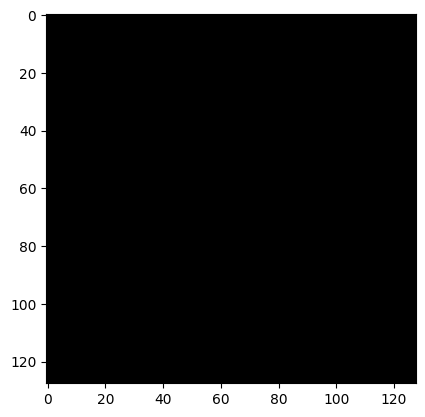

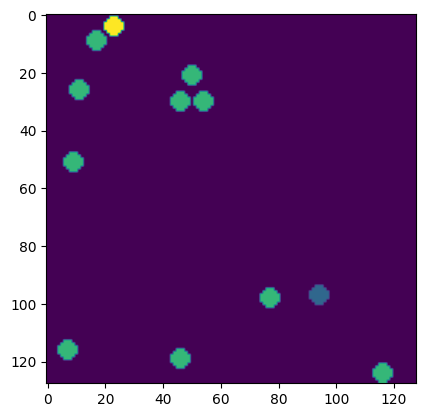

In [15]:

print(f"Rozmiar train_images_np: {train_images_np.shape}")

index = 330
plt.imshow(train_images_np[index])
plt.show()

plt.imshow(np.argmax(train_masks_np[index], axis=-1))
plt.show()

**Trenowanie modelu**

In [16]:
filters_list = [[8, 16, 32, 64, 128]]


batch_size_list = [2, 4, 10, 16]


epochs_list = [100, 200]

run_training(train_images_np, train_masks_np, val_images_np, val_masks_np, test_images_np, test_masks_np, filters_list, batch_size_list, epochs_list)


Trening modelu z 1 U-Net, 128 filtrami, batch_size = 2, epochs = 100

Wagi klas: [0.00422225 0.07732831 0.03639482 0.88205462]
Epoch 1/100
646/647 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.7362 - precision: 0.7797 - recall: 0.6991 - iou_metric: 0.4782
Epoch 1: val_loss improved from inf to 0.33152, saving model to Model/1_unets_128_filters\best_model_1_unets_128_filters_100_epoch_2_batch.h5
647/647 [==============================] - 29s 32ms/step - loss: 0.2861 - accuracy: 0.7361 - precision: 0.7797 - recall: 0.6991 - iou_metric: 0.4782 - val_loss: 0.3315 - val_accuracy: 0.7426 - val_precision: 0.8769 - val_recall: 0.2119 - val_iou_metric: 0.2834 - lr: 0.0010
Epoch 2/100
647/647 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.7255 - precision: 0.7752 - recall: 0.7348 - iou_metric: 0.5230
Epoch 2: val_loss did not improve from 0.33152
647/647 [==============================] - 20s 31ms/step - loss: 0.2634 - accuracy: 0.7255 - precis

**Ewaluacja modelu**

In [17]:
models_folder = './Model'

evaluate_models_in_folders(models_folder, test_images_np, test_masks_np)


Ocena modelu: ./Model\1_unets_128_filters\best_model_1_unets_128_filters_100_epoch_10_batch.h5
22/22 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

  Background       0.85      1.00      0.92   9544150
   Pozytywne       0.00      0.00      0.00    542332
   Negatywne       0.08      0.00      0.00   1137705
         TLL       0.00      0.00      0.00     48005

    accuracy                           0.85  11272192
   macro avg       0.23      0.25      0.23  11272192
weighted avg       0.73      0.85      0.78  11272192

Liczba wszystkich komórek: 21471
Liczba pozytywnych komórek: 9748
Liczba negatywnych komórek: 10806
Liczba komórek TLL: 917
Wykryte pozytywne komórki: 0
Wykryte negatywne komórki: 182
Wykryte komórki TLL: 0
Procent wykrytych pozytywnych komórek: 0.00%
Procent wykrytych negatywnych komórek: 1.68%
Procent wykrytych komórek TLL: 0.00%
Procent wykrytych wszystkich komórek: 0.85%
Precyzja: 0.06
Czułość (Recall): 0.00

**Najleszy model**